<a href="https://colab.research.google.com/github/marriamaslova/DL-NLP-MS/blob/main/Homework2_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [ ]:
with open('processed_corpus.json') as f:
    corpus = json.load(f)

In [ ]:
len(corpus)

100000

In [ ]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

здесь я в качестве sample_text возьму пример который был в оригинальном блокнтое, поскольку его нет в файле processed_corpus

In [ ]:
sample_string = 'вопрос почему например китайский японский UNK'

In [ ]:
sample_text = sample_string.split()

In [ ]:
# sample_text = corpus[1]

In [ ]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом CBOW

In [ ]:
def cbow_split(tokens, window, pad_token='PAD'):
    splits = []

    # Добавление паддинга к предложению
    padded_tokens = [pad_token] * window + tokens + [pad_token] * window

    # Создание примеров CBOW
    for i in range(window, len(tokens) + window):
        left_context = padded_tokens[i - window:i]
        central_word = padded_tokens[i]
        right_context = padded_tokens[i + 1:i + window + 1]

        splits.append((left_context, central_word, right_context))

    return splits

In [ ]:
splits = cbow_split(sample_text, window=2)

In [ ]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [ ]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [ ]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

все ОК, функция работает как и должна работать в примере

# Skipgram

In [ ]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом Skipgram

In [ ]:
def skipgram_split(tokens, window):
    combinations = []

    for i, central_word in enumerate(tokens):
        context = tokens[max(0, i - window):i] + tokens[i + 1:i + window + 1]

        # Пропуск центрального слова, если окно меньше длины предложения
        if context:
            for context_word in context:
                combinations.append((context_word, central_word))

    return combinations

In [ ]:
splits = skipgram_split(sample_text, window=2)

In [ ]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [ ]:
skipgram_split(sample_text, window=2)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [ ]:
skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

и с этой функций все тоже ОК!

In [ ]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [ ]:
len(word2index)

13076

In [ ]:
word2index['UNK']

1

In [ ]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

In [ ]:
word2index['мама']

1282

In [ ]:
word2index['мыть']

8436

In [ ]:
word2index['рама']

KeyError: 'рама'

все работает как нужно

# Torch Dataset
В торче есть очень удобная читалка данных

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [ ]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.42243875, 0.3481138 , 0.07764146, 0.31837627],
       [0.57427272, 0.84584989, 0.73083964, 0.06258062],
       [0.15991503, 0.24795685, 0.95278777, 0.13819613],
       [0.02284906, 0.01535866, 0.72162371, 0.82829307],
       [0.10858419, 0.50987106, 0.19626808, 0.43127971],
       [0.60746532, 0.14543198, 0.65182643, 0.8106798 ],
       [0.42754139, 0.58470381, 0.04544281, 0.97305835],
       [0.6646015 , 0.49535135, 0.16845853, 0.88617953],
       [0.46848547, 0.51256632, 0.46320211, 0.45993959],
       [0.81604332, 0.0860917 , 0.13693794, 0.27580628]])

In [ ]:
some_data_y

array([2, 2, 0, ..., 2, 1, 2])

In [ ]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        return self.data_x[idx], self.data_y[idx]

In [ ]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
some_dataset[5], some_dataset[467]

((array([0.60746532, 0.14543198, 0.65182643, 0.8106798 ]), 0),
 (array([0.64860143, 0.26492627, 0.16341116, 0.14045171]), 2))

In [ ]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [ ]:
for x, y in some_loader:
    break

len(x), x

(16,
 tensor([[0.2885, 0.6688, 0.7926, 0.0760],
         [0.8396, 0.8808, 0.6020, 0.3558],
         [0.3526, 0.2094, 0.8578, 0.1085],
         [0.7382, 0.4996, 0.7609, 0.4446],
         [0.4382, 0.6965, 0.8837, 0.0776],
         [0.2201, 0.6367, 0.1985, 0.4433],
         [0.6075, 0.2269, 0.3712, 0.0795],
         [0.5623, 0.4688, 0.7497, 0.0886],
         [0.6672, 0.5993, 0.7138, 0.3678],
         [0.1160, 0.9422, 0.1657, 0.8788],
         [0.1861, 0.6394, 0.4180, 0.4300],
         [0.6986, 0.0912, 0.6988, 0.6012],
         [0.8017, 0.5216, 0.0811, 0.2940],
         [0.2886, 0.6723, 0.2755, 0.5272],
         [0.8669, 0.0209, 0.2568, 0.1341],
         [0.4078, 0.6380, 0.3888, 0.7900]], dtype=torch.float64))

In [ ]:
for x, y in some_loader:
    pass

len(x)

15

In [ ]:
# почему 15?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [ ]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    @staticmethod
    def add_pow_features(x, n=2):

        return np.concatenate([x, x ** n])

    @staticmethod
    def add_log_features(x):

        return np.concatenate([x, np.log(x)])

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        x = self.data_x[idx]

        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)

        y = self.data_y[idx]

        return x, y

In [ ]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [ ]:
for x, y in toy_loader:
    break

In [ ]:
x.shape

torch.Size([128, 32])

In [ ]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.4224,   0.3481,   0.0776,  ...,  -6.3314, -15.3339,  -6.8671],
        [  0.5743,   0.8458,   0.7308,  ...,  -1.0045,  -1.8814, -16.6278],
        [  0.1599,   0.2480,   0.9528,  ...,  -8.3670,  -0.2902, -11.8745],
        ...,
        [  0.2780,   0.9210,   0.1019,  ...,  -0.4935, -13.7029,  -4.3593],
        [  0.9963,   0.2235,   0.6431,  ...,  -8.9913,  -2.6483,  -2.7432],
        [  0.9333,   0.4992,   0.9858,  ...,  -4.1683,  -0.0856, -28.8796]],
       dtype=torch.float64)

In [ ]:
y

tensor([2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1,
        2, 1, 0, 1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 1,
        1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 2,
        0, 1, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 2, 0, 1, 2, 1, 1, 0,
        2, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)

loss.item()

1.1460011005401611

# Боевые датасеты

In [ ]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [ ]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = "PAD"
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose
        self.data = []
        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        tokens = tokenized_text
        combinations = []

        for i, central_word in enumerate(tokens):
            context = tokens[max(0, i - self.window):i] + tokens[i + 1:i + self.window + 1]

            if context:
                for context_word in context:
                    combinations.append((context_word, central_word))

        return combinations


    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):

        cont, central_word = self.data[idx]
        con = torch.tensor(cont)

        return con, central_word

In [ ]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его
#from .word2vec_utils import SkipgramDataset

In [ ]:
dataset = SkipgramDataset(corpus, word2index)

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 118189.33it/s]


In [ ]:
BATCH_SIZE = 512

In [ ]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
for x, y in dataset_loader:
    break

In [ ]:
x[:5]

tensor([1582,   48, 2367,  114, 6253])

In [ ]:
y[:5]

tensor([5332,  926,  304, 4899, 1218])

In [ ]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [ ]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, pad_index):

        super().__init__()

        if pad_index > 0:
            vocab_size += 1

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)

        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [ ]:
class SkipGram(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):

        super().__init__()


        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x)
        x = self.out_embedding(x)

        return x

In [ ]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 30

In [ ]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [ ]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [ ]:
import numpy as np
from tqdm import tqdm

losses = []
epochs = 10

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:
            output = model(x)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break


Epoch 10: 100%|█████████| 2983124/2983124 [03:46<00:00, 13146.96it/s, loss=6.65]


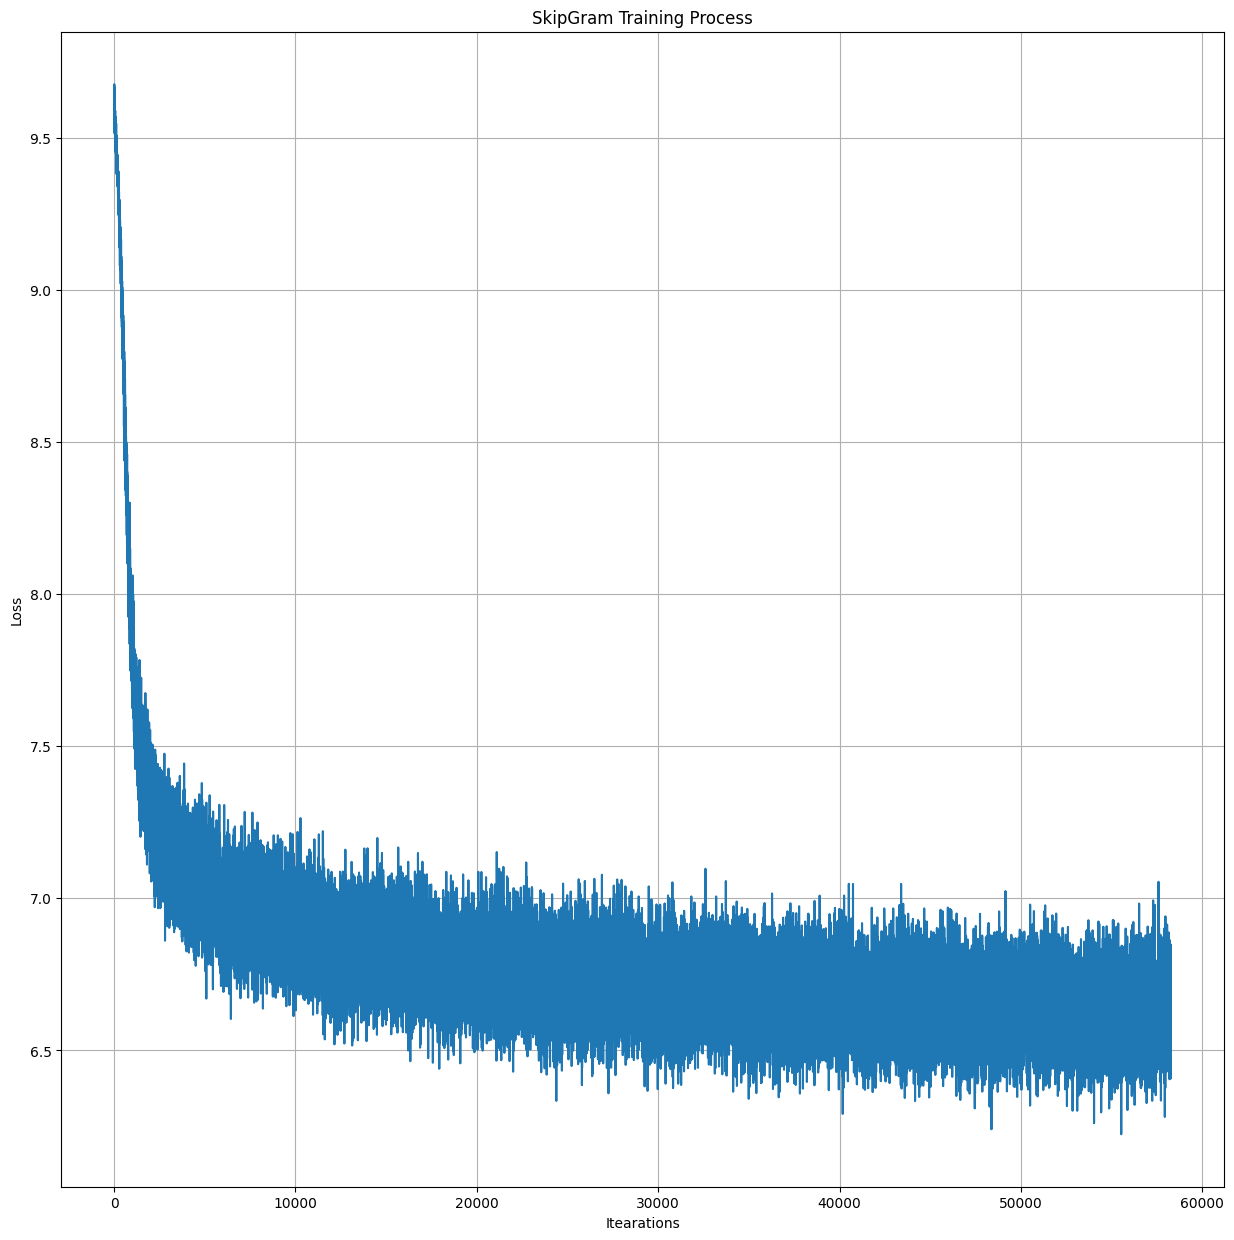

In [ ]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [ ]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [ ]:
embedding_matrix = model.in_embedding.weight.detach()

In [ ]:
def cos_sim(embedding_matrix, token2id, word1, word2):

    i1 = token2id[word1]
    i2 = token2id[word2]

    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]

    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))

    similarity = torch.dot(v1_n, v2_n).item()

    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [ ]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.6950123310089111

In [ ]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5204434394836426

In [ ]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.6031600832939148

In [ ]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.2356187403202057

Видим неплохие цифры для косинусного расстояния. Но, кажется, можно сделать лучше. Лучшие цифры можно получить если, например, построить такую же сеть, только с большим размером окна (т.е предсказывать слово по 3 предыдущим). Также огромную роль играет размер выборки. У нас было всего 100 тыс items, что для качественного решения такой задачи мало.

In [ ]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "ноут" равна 0.192'

In [ ]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [ ]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.000s...
[t-SNE] Computed neighbors for 13076 samples in 0.372s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [ ]:
top_words = [a for a,_ in top_sorted_freq]

In [ ]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

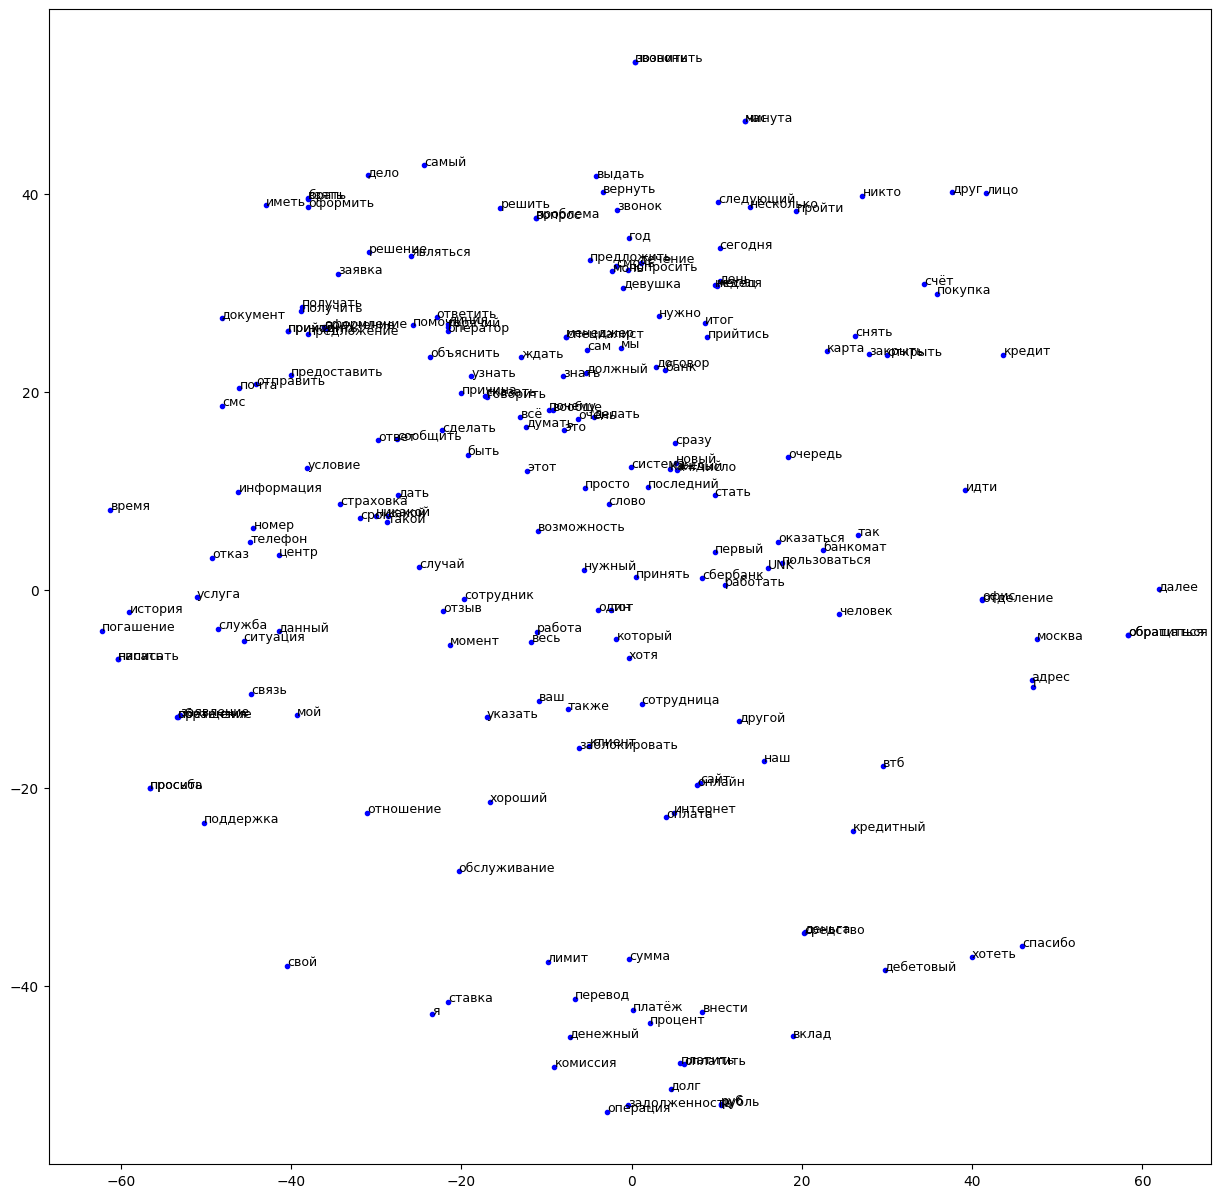

In [ ]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
EMBEDDING_DIM = 20
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

losses = []
epochs = 10

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:
            output = model(x)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 10: 100%|█████████| 2983124/2983124 [03:21<00:00, 14774.10it/s, loss=6.71]


In [ ]:
embedding_matrix = model.in_embedding.weight.detach()

In [ ]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.7127798795700073

In [ ]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.523453950881958

In [ ]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.5966144800186157

In [ ]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.41486215591430664

In [ ]:
cos_sim(embedding_matrix, word2index, 'офис', 'отделение')

0.9110742211341858

In [ ]:
cos_sim(embedding_matrix, word2index, 'сайт', 'онлайн')

0.7529120445251465

## Комментарии и дополнения

Удалось получить хорошие и логичные оценки для близости похожих слов (например, офис - отделение 0.91 или сайт - онлайн 0.75).
Также я провела дополнительные экперименты с размером вектора признаков.
Было две модели с размерностью 20 и 30 соответственно. Каждая обучалась 10 эпох. Оказалось, что модель с размерностью 30 обучилась по метрике cross-entopy loss чуть лучше, чем модель с 20. Но при этом косинусное расстояние для модели с 20 лучше отображает смысл для некоторых слов, а для некоторых слов принципиально по-другому.


При попытке сравнения результата с корпусом для оценки качества выяснилось, что набор слов там сильно отличается от набора слов в нашем корпусе. Кажется,
что такое сравнение бдует не очень релевантным, поскольку переcечение будет не очень высоким. Я проверила несколько популярных слов из нашей выборки и оказалось, что их просто нет в общем корпусе, поскольку наш корпус сильно связан с банковской сферой и в нем мало примеров предложений из повседневной жизни.

In [ ]:
import pandas as pd
df = pd.read_csv('ru_simlex965_tagged.tsv', sep = '\t')

In [ ]:
df['word1'] = df['# Word1'].apply(lambda x: x.split("_")[0])
df['word2'] = df['Word2'].apply(lambda x: x.split("_")[0])

In [ ]:
df.head()

,# Word1,Word2,Average Score,word1,word2
0,авария_NOUN,бедствие_NOUN,6.15,авария,бедствие
1,август_NOUN,месяц_NOUN,2.85,август,месяц
2,авиация_NOUN,полет_NOUN,6.77,авиация,полет
3,автомобиль_NOUN,гудок_NOUN,1.85,автомобиль,гудок
4,автомобиль_NOUN,автострада_NOUN,1.23,автомобиль,автострада


In [ ]:
top_words[1:10]

['банк', 'карта', 'UNK', 'кредит', 'это', 'деньга', 'день', 'мой', 'сотрудник']

In [ ]:
"банк" in df.word1.unique()

False

In [ ]:
"кредит" in df.word1.unique()

False

In [ ]:
"мой" in df.word1.unique()

False

In [ ]:
"это" in df.word1.unique()

False

In [ ]:
"сотрудник" in df.word1.unique()

False

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов